In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
DEVICE = 'cpu'

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR10",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR10",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR10\cifar-10-python.tar.gz to ../data/CIFAR10


In [5]:
train,target =  train_dataset[0]
print(train.shape,  target)
np.transpose(train,(1,2,0)).shape

torch.Size([3, 32, 32]) 6


torch.Size([32, 32, 3])

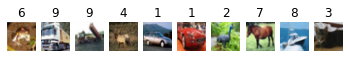

In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
# train 데이터를 10개만 가져오자
for cnt, (x,y) in enumerate(train_dataset):
    if cnt >= 10: break 
    plt.subplot(1,10,cnt+1)
    plt.axis('off')
    # TypeError: Invalid shape (3, 32, 32) for image data
    plt.imshow(np.transpose(x, (1,2,0)))    
    plt.title(y)

In [7]:
# 분류 10 설계  MLP
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
    def forward(self,x):
        x = x.view(-1,32*32*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x     

In [8]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
# model.train()  전체 레이어를 사용 : 전체 layer의 전원을 켠다
# model.eval() evaluation, 사용하지 않는 layer들의 전원을 끈다
from tqdm import tqdm # 진행상황을 progress bar로 표시
def train(model, train_loader,optimizer):
    model.train()
    for image, label in tqdm(train_loader):  # 배치단위로 출력
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
for epoch in range(1, EPOCHS+1):
    train(model,train_loader,optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"epoch : {epoch}  loss : {test_loss}, accuracy : {test_accuracy}")

100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:52<00:00, 29.59it/s]


epoch : 1  loss : 0.04449019541740418, accuracy : 49.93


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:53<00:00, 29.30it/s]


epoch : 2  loss : 0.04548793338537216, accuracy : 49.46


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:53<00:00, 29.30it/s]


epoch : 3  loss : 0.044345379251241684, accuracy : 49.94


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:52<00:00, 29.63it/s]


epoch : 4  loss : 0.04509175981283188, accuracy : 49.45


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:53<00:00, 28.96it/s]


epoch : 5  loss : 0.04497474530935287, accuracy : 49.73


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:53<00:00, 29.30it/s]


epoch : 6  loss : 0.04552960196733475, accuracy : 49.42


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:52<00:00, 29.58it/s]


epoch : 7  loss : 0.0451072665989399, accuracy : 49.28


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:53<00:00, 29.45it/s]


epoch : 8  loss : 0.04550963172912598, accuracy : 49.34


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:53<00:00, 29.19it/s]


epoch : 9  loss : 0.04702730674743652, accuracy : 48.73


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:53<00:00, 29.27it/s]


epoch : 10  loss : 0.04450879006385803, accuracy : 50.41


In [13]:
# CNN 모델 설계
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 8,
            kernel_size = 3,
            padding = 1
        )
        self.conv2 = nn.Conv2d(
            in_channels = 8, out_channels = 16,
            kernel_size = 3,
            padding = 1
        )
        self.pool = nn.MaxPool2d(
            kernel_size =2, stride = 2
        )

        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
  
    def forward(self, x):
        # x = (32, 32, 3)        
        x = self.conv1(x) # x = (32, 32, 3) ## len(x) - kernel_size + 1        
        x = F.relu(x)
        x = self.pool(x) # x = (16, 16, 3)        
        x = self.conv2(x) # x = (16, 16, 3)         
        x = F.relu(x)
        x = self.pool(x) # x = (8, 8, 3)        

        x = x.view(-1, 8* 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x,dim=1)

        return x

In [14]:
cnnModel = CNN().to(DEVICE)
optimizer = torch.optim.Adam(cnnModel.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
for epoch in range(1, EPOCHS+1):
    train(cnnModel,train_loader,optimizer)
    test_loss, test_accuracy = evaluate(cnnModel, test_loader)
    print(f"epoch : {epoch}  loss : {test_loss}, accuracy : {test_accuracy}")    


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:20<00:00, 76.78it/s]


epoch : 1  loss : 0.06447383868694305, accuracy : 39.52


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:20<00:00, 75.36it/s]


epoch : 2  loss : 0.06330822879076003, accuracy : 43.46


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:19<00:00, 80.69it/s]


epoch : 3  loss : 0.06240986853837967, accuracy : 46.54


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:20<00:00, 75.71it/s]


epoch : 4  loss : 0.0616392288684845, accuracy : 48.86


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:20<00:00, 75.33it/s]


epoch : 5  loss : 0.06164100136756897, accuracy : 48.59


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 71.94it/s]


epoch : 6  loss : 0.060954496610164645, accuracy : 51.09


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:20<00:00, 78.12it/s]


epoch : 7  loss : 0.060208612048625945, accuracy : 53.36


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:20<00:00, 76.59it/s]


epoch : 8  loss : 0.060614410364627835, accuracy : 52.09


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:19<00:00, 79.66it/s]


epoch : 9  loss : 0.059891336262226105, accuracy : 54.28


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:19<00:00, 79.58it/s]


epoch : 10  loss : 0.059036744582653046, accuracy : 57.23


In [15]:
# Data 변형해서 데이터 증폭

train_dataset = datasets.CIFAR10(root = "../data/CIFAR10",
                                      train = True,
                                      download = True,
                                      transform = transforms.Compose([
                                          transforms.RandomHorizontalFlip(), # 좌우반전(50%확률)
                                          transforms.ToTensor(),  # 정규화(0~1) 및 텐서
                                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # 데이터 정규화
                                      ])
                                )

test_dataset = datasets.CIFAR10(root = "../data/CIFAR10",
                                     train = False,
                                     transform = transforms.Compose([
                                          transforms.RandomHorizontalFlip(), # 좌우반전(50%확률)
                                          transforms.ToTensor(),  # 정규화(0~1) 및 텐서
                                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # 데이터 정규화
                                      ])
                               )

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

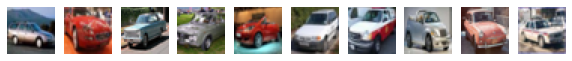

In [17]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

temp = np.array(train_dataset.targets)
np.where(temp==1)
temp2 = train_dataset.data[np.where(temp==1)]
# class 1인 이미지
plt.figure(figsize=(10,10))
for cnt, x in enumerate(temp2):    
    if cnt >= 10: break 
    plt.subplot(1,10,cnt+1)
    plt.axis('off')    
    plt.imshow(x)      


In [18]:
# 증폭된 데이터 이미지로 학습하기
cnnModel = CNN().to(DEVICE)
optimizer = torch.optim.Adam(cnnModel.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
for epoch in range(1, EPOCHS+1):
    train(cnnModel,train_loader,optimizer)
    test_loss, test_accuracy = evaluate(cnnModel, test_loader)
    print(f"epoch : {epoch}  loss : {test_loss}, accuracy : {test_accuracy}")  

100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 62.54it/s]


epoch : 1  loss : 0.06315731147527695, accuracy : 43.88


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.84it/s]


epoch : 2  loss : 0.06163698579072952, accuracy : 48.72


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 60.49it/s]


epoch : 3  loss : 0.060939087426662444, accuracy : 50.99


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.59it/s]


epoch : 4  loss : 0.060069010853767396, accuracy : 54.03


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.69it/s]


epoch : 5  loss : 0.05997209212779999, accuracy : 54.17


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.55it/s]


epoch : 6  loss : 0.05948001257181167, accuracy : 55.8


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.06it/s]


epoch : 7  loss : 0.05880884313583374, accuracy : 57.93


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.46it/s]


epoch : 8  loss : 0.05897953097820282, accuracy : 57.43


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 61.26it/s]


epoch : 9  loss : 0.058342510950565335, accuracy : 59.36


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 62.59it/s]


epoch : 10  loss : 0.05872849740982056, accuracy : 58.17


# CNN 아키텍처
### ImageNet
- 이미지 분류 모델을 측정하기 위한 데이터로 가장 많이 사용되는 데이터
### Network Architecture
- 네트워크의 성능을 높이기 위한 구조, 깊게 쌓으면서 과적합을 방지하고자 하는 연구.
### LeNet
- 최초의 CNN모델. (1990년대에 나온 모델이므로 비교적 단순한 구조를 가지고 있음)
### Alexnet
- 2012 ILSVRC 대회 우승 모델. 구조는 크게 다르지 않지만 Dropoout, DataAugmentation등을 적용했다.
### VGG
- 2014 ILSVRC 대회에서 2등을 차지한 모델.
- 3*3 합성곱 층을 깊게 중첩하는 것이 특징
### GoogLeNet
- 2014 ILSVRC 대회에서 1등한 모델.
- Inception 구조를 처음 적용하고 Gloval Average Pooling 을 처음 적용했음.
### ResNet
- 2015 ILSVRC 대회에서 1등. 이미지 분류의 기본 모델로 사용하고 있음.
- Residual Block 이란 개념 도입. (이전 층의 feature Map을 다음 층의 feature map 에 더해줌) -> 기울기 소실 제거
### DenseNet
- ResNet의 확장형 버전. 모든 층에 대해 Skip connection 을 연결한다.